# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  sf2796
* Name: Sicong Fang

### Team Member 2 [optional]:
* UNI:  hz2432
* Name: Haiqi Zhu


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

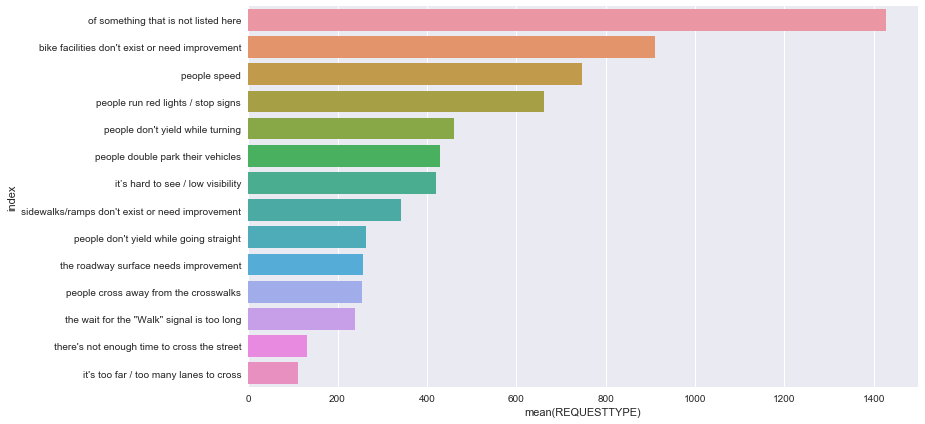

In [70]:
# Add your code for task 1 here. You may use multiple cells. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import re
#sys.stdout = stdout
%matplotlib inline

data=pd.read_csv('Vision_Zero_Entry.csv')
data.head()

data1=data[-data['COMMENTS'].isnull()].drop_duplicates()
#sum(data1['COMMENTS'].isnull())
data1['REQUESTTYPE']=data1['REQUESTTYPE'].str.replace(r'".*?;','',case=False)
data1['REQUESTTYPE']=data1['REQUESTTYPE'].iloc[:].replace({'there are no bike facilities or they need maintenance':"bike facilities don't exist or need improvement",
                                                  "the roadway surface needs maintenance":"the roadway surface needs improvement",
                                                  'people have to wait too long for the "Walk" signal':'the wait for the "Walk" signal is too long',
                                                   'it’s hard for people to see each other':'it’s hard to see / low visibility',
                                                  "people have to cross too many lanes / too far":"it's too far / too many lanes to cross",
                                                  "people are not given enough time to cross the street":"there's not enough time to cross the street",
                                                          "there are no sidewalks or they need maintenance":"sidewalks/ramps don't exist or need improvement"})
data1['REQUESTTYPE']=data1['REQUESTTYPE'].iloc[:].replace({"it’s":"it's"})
data2=pd.DataFrame(data1['REQUESTTYPE'].value_counts())

data2=data2.reset_index()
plt.figure(figsize=(12,7))
sns.barplot(y="index",x="REQUESTTYPE",data=data2,orient='h')



# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [2]:
# Add your code for task 2 here. You may use multiple cells. 
X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
y_cat=label.fit_transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train=vect.fit_transform(X_train)
X_test=vect.transform(X_test)

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
log=LogisticRegressionCV(multi_class='multinomial').fit(X_train,y_train)
y_pred=log.predict(X_test)



In [3]:
# Get f1 score
print ('Macro F1 Score for task 1 (Logistic Regression) is :')
f1_score(y_test,y_pred,average='macro')

Macro F1 Score for task 1 (Logistic Regression) is :


0.57206786903060092

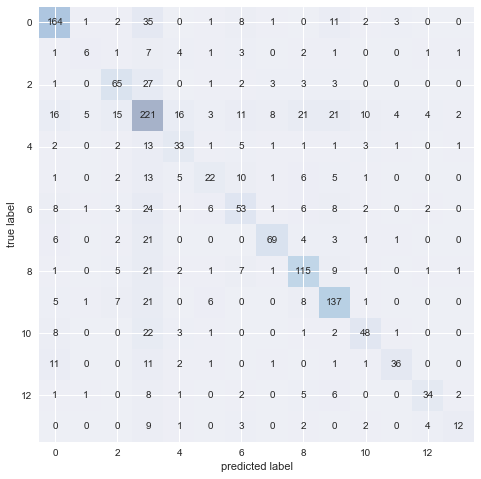

In [4]:
#Visulaize confusion matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred, 
                      binary=False)



fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(12,8))

plt.show()

** Mistake: It did not count the order of words, so that things like negations(safe/Not safe) are not captured. Since it ignore semantic meaning, accuracy is affected. It also ignores incorrect spellings and made-up words. ** 

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [5]:
# Add your code for task 3 here. You may use multiple cells. 
# 2-grams
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import make_pipeline

X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
y_cat=label.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)

cv2_trans=TfidfVectorizer(ngram_range=(1,2), min_df=4, stop_words='english')
X_train_tf = cv2_trans.fit_transform(X_train)
X_test_tf = cv2_trans.transform(X_test)
model1 = LogisticRegressionCV().fit(X_train_tf, y_train)
y_pred1=model1.predict(X_test_tf)



In [6]:
#3-grams
X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
label=LabelEncoder()
y_cat=label.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)
cv3=make_pipeline(CountVectorizer(ngram_range=(1,3), min_df=3, stop_words='english'),TfidfTransformer(),LogisticRegression(multi_class='multinomial',solver='lbfgs'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid3 = GridSearchCV(cv3, param_grid, cv=5)
y_pred2=cv3.fit(X_train,y_train).predict(X_test)

In [7]:
#4-grams
X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
y_cat=label.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)
cv4=make_pipeline(CountVectorizer(ngram_range=(1,4), min_df=3, stop_words='english'),TfidfTransformer(),LogisticRegressionCV(multi_class='multinomial',solver='lbfgs'))
y_pred3=cv4.fit(X_train,y_train).predict(X_test)

In [71]:
# #character n-grams
# X=data1['COMMENTS']
# y=data1['REQUESTTYPE']

# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import GridSearchCV
# label=LabelEncoder()
# y_cat=label.fit_transform(y)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)
# character_gram=make_pipeline(CountVectorizer(ngram_range=(2, 5), min_df=4, analyzer="char_wb"),LogisticRegressionCV(multi_class='multinomial',solver='lbfgs'))
# #param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
# #grid3 = GridSearchCV(cv3, param_grid, cv=5)
# y_pred4=character_gram.fit(X_train,y_train).predict(X_test)

In [8]:
# #possibly domain-specific features
# import re
# import spacy
# import nltk
# # regexp used in CountVectorizer
# regexp = re.compile('(?u)\\b\\w\\w+\\b')
# # load spacy language model and save old tokenizer
# en_nlp = spacy.load('en')
# old_tokenizer = en_nlp.tokenizer
# # replace the tokenizer with the preceding regexp
# en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
# regexp.findall(string))
# # create a custom tokenizer using the spacy document processing pipeline
# # (now using our own tokenizer)
# def custom_tokenizer(document):
#     doc_spacy = en_nlp(document, entity=False, parse=False)
#     return [token.lemma_ for token in doc_spacy]
# # define a count vectorizer with the custom tokenizer
# lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=3)
# X_train_lemma = lemma_vect.fit_transform(X_train)
# X_test_lemma = lemma_vect.transform(X_test)
# from sklearn.model_selection import StratifiedShuffleSplit
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,train_size=0.01, random_state=0)
# grid4 = GridSearchCV(LogisticRegression(), param_grid, cv=cv)
# grid4.fit(X_train_lemma, y_train)
# y_pred4=grid4.predict(X_test_lemma)
# print ('Macro F1 Score (lemmatization):'), f1_score(y_test,y_pred4,average='macro')

Macro F1 Score (lemmatization):


(None, 0.56617438202312342)

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

Macro F1 Score for task 2 (Bi-gram) is : 0.563179681327
Macro F1 Score for task 2 (Tri-gram) is : 0.529707589171
Macro F1 Score for task 2 (Four-gram) is : 0.564273972259


/Users/haiki/miniconda2/envs/py361/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


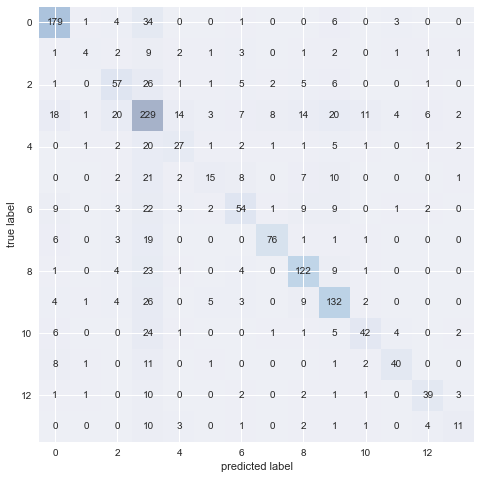

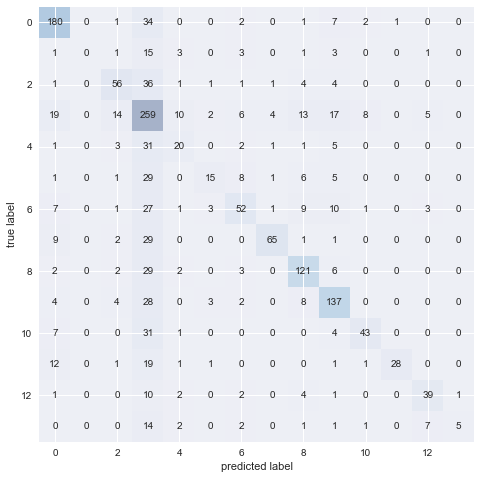

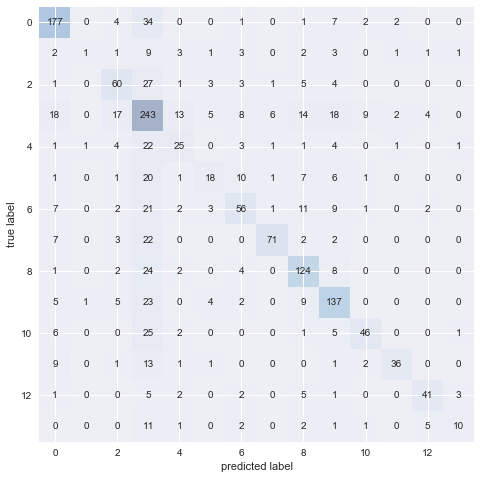

In [9]:
# Add your code for task 4 here. You may use multiple cells. 

#classfication results and confusion matrix
print (('Macro F1 Score for task 2 (Bi-gram) is :'), f1_score(y_test,y_pred1,average='macro'))
print (('Macro F1 Score for task 2 (Tri-gram) is :'), f1_score(y_test,y_pred2,average='macro'))
print (('Macro F1 Score for task 2 (Four-gram) is :'), f1_score(y_test,y_pred3,average='macro'))
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm1 = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred1, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm1,figsize=(12,8))

plt.show()
cm2 = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred2, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm2,figsize=(12,8))

plt.show()
cm3 = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred3, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm3,figsize=(12,8))

plt.show()


3668


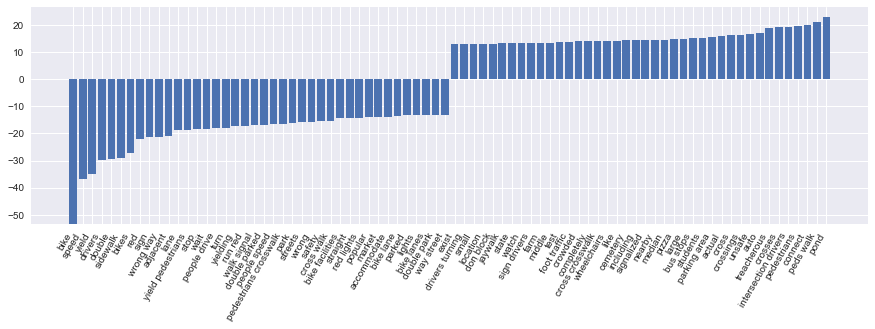

In [65]:
#important features
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    coef = model1.coef_.sum(axis=0)
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

feature_name = cv2_trans.get_feature_names()
print (len(feature_name))
plt.figure(figsize=(15, 4))
plot_important_features(model1.coef_.ravel(), np.array(feature_name), top_n=40)

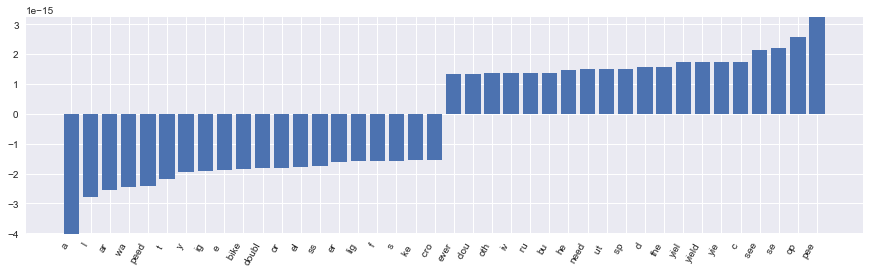

In [72]:
# def plot_important_features(coef, feature_names, top_n=20, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     coef = character_gram.named_steps['logisticregressioncv'].coef_.sum(axis=0)
#     inds = np.argsort(coef)
#     low = inds[:top_n]
#     high = inds[-top_n:]
#     important = np.hstack([low, high])
#     myrange = range(len(important))

#     ax.bar(myrange, coef[important])
#     ax.set_xticks(myrange)
#     ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

# plt.figure(figsize=(15, 4))
# plot_important_features(character_gram.named_steps['logisticregressioncv'].coef_.ravel(), np.array(character_gram.named_steps['countvectorizer'].get_feature_names()), top_n=20)

Best cross-validation score: 0.60
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}


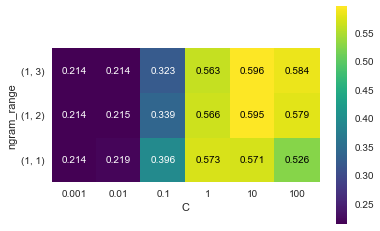

In [12]:
# from sklearn.model_selection import GridSearchCV
# pipe = make_pipeline(TfidfVectorizer(min_df=3), LogisticRegression())
# param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
# "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
# grid = GridSearchCV(pipe, param_grid, cv=5)
# grid.fit(X_train, y_train)
# print("Best cross-validation score: {:.2f}".format(grid.best_score_))
# print("Best parameters:\n{}".format(grid.best_params_))
# scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# # visualize heat map
# import mglearn.tools
# heatmap = mglearn.tools.heatmap(
# scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
# xticklabels=param_grid['logisticregression__C'],
# yticklabels=param_grid['tfidfvectorizer__ngram_range'])
# plt.colorbar(heatmap)

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [48]:
# Add your code for task 5 here. You may use multiple cells. 
#LDA 
X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
label=LabelEncoder()
y_cat=label.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)
from sklearn.decomposition import LatentDirichletAllocation
# vect = CountVectorizer(max_features=10000, max_df=.15)
# X_cv= vect.fit_transform(X)
# X_lemma = lemma_vect.fit_transform(X)

from sklearn.metrics.cluster import adjusted_rand_score
lda = make_pipeline(CountVectorizer(max_features=300, max_df=.95),
                   LatentDirichletAllocation(n_topics=10, learning_method="batch", max_iter=25, learning_offset=50,random_state=0))
document_topics = lda.fit_transform(X)
rst_lda = document_topics.argmax(axis=1)
print(adjusted_rand_score(rst_lda, y_cat))
sorting = np.argsort(lda.named_steps['latentdirichletallocation'].components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(lda.named_steps['countvectorizer'].get_feature_names())
from mglearn.tools import print_topics
print_topics(topics=range(10), feature_names=feature_names,
sorting=sorting, topics_per_chunk=5, n_words=10)

0.0948362223613
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
the           to            to            street        light         
stop          the           the           people        the           
and           not           cars          down          red           
at            pedestrians   it            speed         lights        
is            cross         from          way           on            
this          walk          on            to            green         
there         do            see           and           run           
to            crosswalk     st            this          cars          
sign          yield         is            the           at            
of            don           coming        drive         and           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      ---

In [54]:
# Add your code for task 5 here. You may use multiple cells. 
# Topic Extraction with Latent Dirichlet Allocation (LDA)
from mglearn.tools import print_topics
from sklearn.decomposition import LatentDirichletAllocation
X=data1['COMMENTS']
model_03 = make_pipeline(CountVectorizer(stop_words='english',
                                         max_df=0.95,
                                         min_df=2,
                                         max_features=300),
                         LatentDirichletAllocation(n_topics=6,
                                                   learning_method='batch',
                                                   learning_offset=50.,
                                                   random_state=0))
y_pred = model_03.fit_transform(X)
rst_lda = y_pred.argmax(axis=1)
print_topics(range(6),
             np.array(model_03.named_steps['countvectorizer'].get_feature_names()),
             np.argsort(model_03.named_steps['latentdirichletallocation'].components_, axis=1)[:, ::-1],
             n_words=7)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      --------      
bike          stop          cars          lane          light         street        
lanes         intersection  street        left          walk          speed         
lane          crosswalk     sidewalk      turn          red           people        
parking       st            park          right         pedestrians   way           
park          cross         parked        cars          cars          traffic       
double        sign          people        bike          cross         road          
lot           people        traffic       traffic       signal        drive         




### Interpretaions of topics: ###
**Topic 1: Bike don't follow traffic rules **

**Topic 2: People don't stop/follow rules at intersection**

**Topic 3:  Cars don't park in right place**

**Topic 4: Traffic caused by making inproper left/right turns**

**Topic 5: People don't follow traffic light** 

**Topic 6:  Speed issue**

In [46]:
rst_lda = document_topics.argmax(axis=1)
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(rst_lda, y_cat)

0.081952821781108354

violation: 1.0
violation: 0.4478041290874875
violation: 0.27675778112076954
violation: 0.19080738711010242
violation: 0.141369067979247
violation: 0.11285863122621737
violation: 0.09195351538766736
violation: 0.074606747427558
violation: 0.060529741961602955
violation: 0.04969295175398077
violation: 0.04091523680984818
violation: 0.0340357258806414
violation: 0.028776005120428633
violation: 0.02486323965176911
violation: 0.0220878539970636
violation: 0.02008997651412814
violation: 0.01862607340706467
violation: 0.017544544357022844
violation: 0.016791804799714864
violation: 0.016278832593440186
violation: 0.015991389016692482
violation: 0.015824265497952492
violation: 0.015664692941280565
violation: 0.015479504959339705
violation: 0.01522022098591126
violation: 0.014838530360084095
violation: 0.01430649953970922
violation: 0.013579008165465872
violation: 0.0127176076639429
violation: 0.011734952019115362
violation: 0.010644672961861773
violation: 0.009546586085245773
Converged at itera

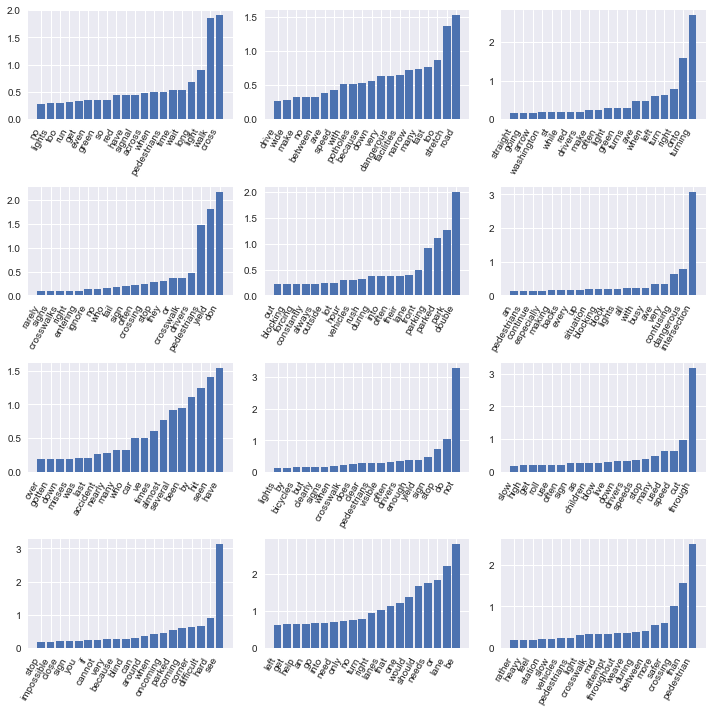

In [17]:
#NMF
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
X=data1['COMMENTS']
from sklearn.preprocessing import MaxAbsScaler
scaler=MaxAbsScaler()
vect = CountVectorizer(max_features=10000, max_df=.15)
X_cv = vect.fit_transform(X)
X_scaled=scaler.fit_transform(X_cv)

from sklearn.decomposition import NMF
nmf=NMF(n_components=14,verbose=10,tol=0.01)
nmf.fit(X_scaled)
X_nmf_scale = nmf.transform(X_scaled)

large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[-12:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [18]:
rst_NMF = X_nmf_scale.argmax(axis=1)

In [19]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(rst_lda, rst_NMF)

0.12085149488510817

In [20]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")
        
sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(large_comp_inds, feature_names, sorting)

topic 1       topic 9       topic 2       topic 8       topic 7       topic 10      
--------      --------      --------      --------      --------      --------      
nonstandard   pembroke      clothing      fletcher      onto          nahant        
simply        strips        tear          stay          solutions     solely        
responded     assumes       redlight      allowance     road          aggressive    
respects      scared        redlands      recording     aren          remind        
respectively  forsyth       rediculously  record        250           remember      
respective    scarcely      redgate       recontoured   rlane         bridj         
badly         scams         redford       anytime       claradon      remaining     
respecting    cues          redfield      consideration riverway      remain        
asticou       announces     blasi         reconstructionriverside     afternoon     
elements      healy         carruth       reconsidered  rivers   

In [21]:
#K-means
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
X=data1['COMMENTS']
X_cv = vect.fit_transform(X)

#svd = TruncatedSVD(100)
#normalizer = Normalizer(copy=False)
#lsa = make_pipeline(svd, normalizer)

#X_kmean = lsa.fit_transform(X_cv)
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
X_kmean=km.fit(X_cv)


print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(10):
    print("Topic %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

print(km.labels_)

# fig = plt.figure(figsize=(15, 10))
# fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# colors = ['#4EACC5', '#FF9C34', '#4E9A06','#c9b555','#83fab0','#eb05b8','#0f381f','#1013ca','#ac1a90','#641064']
# from sklearn.metrics.pairwise import pairwise_distances_argmin
# mbk_means_cluster_centers = np.sort(km.cluster_centers_, axis=0)
# mbk_means_labels = pairwise_distances_argmin(X_cv, mbk_means_cluster_centers)
# ax = fig.add_subplot(1, 3, 2)
# for k, col in zip(range(10), colors):
#     my_members = mbk_means_labels == k
#     cluster_center = mbk_means_cluster_centers[k]
#     ax.plot(X_kmean[my_members, 0], X_kmean[my_members, 1], 'w',
#             markerfacecolor=col, marker='.',label="Cluster %d:" % k)
#     ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#             markeredgecolor='k', markersize=6)

# ax.legend()   
# ax.set_title('MiniBatchKMeans')
# ax.set_xticks(())
# ax.set_yticks(())

Top terms per cluster:
Topic 0: stop lights block line washington crosswalk drivers past st aren
Topic 1: be intersection st very no speed lane not dangerous cross
Topic 2: lane left turn right lanes straight into only go drivers
Topic 3: day all dunks err rotary next every middle or be
Topic 4: that routinely heavy sped yielding priscilla private blenford connects no
Topic 5: crosswalk stop pedestrians drivers not do they or yield cross
Topic 6: parking front double tip most nights tap room weekend very
Topic 7: their very have public away place trash home stores dirty
Topic 8: light turn have walk no st right cross red left
Topic 9: best up aren even slowing flooring though then st down
[2 8 8 ..., 5 5 1]


In [22]:
adjusted_rand_score(km.labels_, y_cat)

0.017246181555891138

In [23]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import Normalizer
# from sklearn import metrics

# from sklearn.cluster import KMeans, MiniBatchKMeans
# X=data1['COMMENTS']
# X_cv = vect.fit_transform(X)

# svd = TruncatedSVD(100)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)

# X_kmean = lsa.fit_transform(X_cv)
# km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1,
#                          init_size=1000, batch_size=1000)
# document_topics=km.fit(X_cv)

# sorting = np.argsort(document_topics.labels_, axis=0)
# print (sorting)
# # Get the feature names from the vectorizer
# feature_names = np.array(vect.get_feature_names())
# print (feature_names)
# from mglearn.tools import print_topics
# print_topics(topics=range(10), feature_names=feature_names,
# sorting=sorting, topics_per_chunk=5, n_words=10)

** We conducted topic modeling using 5,7,10, 14 topics and found that the ARI score is very low. It indicates that there cluesters are different from ground truth.**

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [89]:
# Conduct a topic modeling usong LDA for all comments with 6 topics. Treat it as ground truth and run a logistic regression for it* 

X=data1['COMMENTS']
y_cat=rst_lda


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
vect = TfidfVectorizer(ngram_range=(1,3), min_df=4, stop_words='english')
X_train=vect.fit_transform(X_train)
X_test=vect.transform(X_test)

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
log=LogisticRegressionCV(multi_class='multinomial', Cs=10).fit(X_train,y_train)
y_pred=log.predict(X_test)

print ('Macro F1 Score for task 1 (Logistic Regression) is :')
f1_score(y_test,y_pred,average='macro')

Macro F1 Score for task 1 (Logistic Regression) is :


0.85674135026723641

In [91]:
def test_accuracy():
    score = f1_score(y_test,y_pred,average='macro')
    print(score)
    assert score > 0.53
test_accuracy()

0.856741350267


In [56]:
# Add your code for task 6 here. You may use multiple cells. 
X=data1[data1['REQUESTTYPE']=='of something that is not listed here']["COMMENTS"]
y=data1[data1['REQUESTTYPE']=='of something that is not listed here']["REQUESTTYPE"]

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
label=LabelEncoder()
y_cat=label.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)
from sklearn.decomposition import LatentDirichletAllocation
vect = CountVectorizer(stop_words='english',
                                         max_df=0.95,
                                         min_df=2,
                                         max_features=300)
X_cv= vect.fit_transform(X)
# X_lemma = lemma_vect.fit_transform(X)

from sklearn.metrics.cluster import adjusted_rand_score
# for i in {2, 3, 4, 5}:
#     lda = LatentDirichletAllocation(n_topics=i, learning_method="batch",
#     max_iter=25, random_state=0)
#     document_topics = lda.fit_transform(X_cv)
#     rst_lda = document_topics.argmax(axis=1)
#     print(adjusted_rand_score(rst_lda, y_cat))
#     sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
#     # Get the feature names from the vectorizer
#     feature_names = np.array(vect.get_feature_names())
#     from mglearn.tools import print_topics
#     print_topics(topics=range(i), feature_names=feature_names,
#     sorting=sorting, topics_per_chunk=5, n_words=20)

In [57]:
lda = LatentDirichletAllocation(n_topics=6,learning_method='batch',learning_offset=50.,random_state=0)
lda_other = LatentDirichletAllocation(n_topics=4,learning_method='batch',learning_offset=50.,random_state=0)
rst_lda4 = lda_other.fit_transform(X_cv)


*We did a topic modeling for comments belonging to ''of something that is not listed here' with 4 topics. After examing the top words from each topic, we found some of the topics are very similar to the ones in the original request type. So, we combined them together.*

In [58]:
new_cluster = rst_lda4.argmax(axis=1)
i = 0
for obid in data1[data1['REQUESTTYPE']=='of something that is not listed here']['OBJECTID']:
    if new_cluster[i] == 0:
        data1.loc[data1['OBJECTID']==obid,'REQUESTTYPE'] = 'people cross away from the crosswalks'
    elif new_cluster[i] == 1:
        data1.loc[data1['OBJECTID']==obid,'REQUESTTYPE'] = 'Traffic caused  by chaos at intersection'
    elif new_cluster[i] == 2:
        data1.loc[data1['OBJECTID']==obid,'REQUESTTYPE'] = 'people double park their vehicles'
    else:
        data1.loc[data1['OBJECTID']==obid,'REQUESTTYPE'] = "people don't yield while turning"
    i = i + 1
        

In [59]:
data2=pd.DataFrame(data1['REQUESTTYPE'].value_counts())
data2

,REQUESTTYPE
people don't yield while turning,1163
bike facilities don't exist or need improvement,910
people speed,746
people double park their vehicles,737
people run red lights / stop signs,662
people cross away from the crosswalks,467
it’s hard to see / low visibility,420
sidewalks/ramps don't exist or need improvement,343
people don't yield while going straight,264
the roadway surface needs improvement,256


In [60]:
X=data1['COMMENTS']
y=data1['REQUESTTYPE']

from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
y_cat=label.fit_transform(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,stratify=y_cat, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
vect = TfidfVectorizer(ngram_range=(1,3), min_df=4, stop_words='english')
X_train=vect.fit_transform(X_train)
X_test=vect.transform(X_test)

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
log=LogisticRegressionCV(multi_class='multinomial', Cs=10).fit(X_train,y_train)
y_pred=log.predict(X_test)

print ('Macro F1 Score for task 1 (Logistic Regression) is :')
f1_score(y_test,y_pred,average='macro')

Macro F1 Score for task 1 (Logistic Regression) is :


0.51286088136390373

# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [81]:
data=pd.read_csv('Vision_Zero_Entry.csv')
data.head()

data1=data[-data['COMMENTS'].isnull()].drop_duplicates()
#sum(data1['COMMENTS'].isnull())
data1['REQUESTTYPE']=data1['REQUESTTYPE'].str.replace(r'".*?;','',case=False)
data1['REQUESTTYPE']=data1['REQUESTTYPE'].iloc[:].replace({'there are no bike facilities or they need maintenance':"bike facilities don't exist or need improvement",
                                                  "the roadway surface needs maintenance":"the roadway surface needs improvement",
                                                  'people have to wait too long for the "Walk" signal':'the wait for the "Walk" signal is too long',
                                                   'it’s hard for people to see each other':'it’s hard to see / low visibility',
                                                  "people have to cross too many lanes / too far":"it's too far / too many lanes to cross",
                                                  "people are not given enough time to cross the street":"there's not enough time to cross the street",
                                                          "there are no sidewalks or they need maintenance":"sidewalks/ramps don't exist or need improvement"})

In [82]:
X=data1['COMMENTS']
y_cat=rst_lda
y_cat

X_ex_train, X_ex_test,y_ex_train,y_ex_test=train_test_split(X,y_cat)

In [83]:
# Add your code for extra credit here. You may use multiple cells. 
# X=data1['COMMENTS']
# y_cat=rst_lda
import gensim

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

train_corpus = list(read_corpus(X_ex_train))
# # train_corpus
test_corpus = list(read_corpus(X_ex_test, tokens_only=True))
model = gensim.models.doc2vec.Doc2Vec(size=300, min_count=2, iter=55)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count,epochs=model.iter)


4895012

In [88]:
# import pickle
# with open("doc2vec_300.pickle", "wb") as f:
#     pickle.dump(model, f, -1)

# vectors = [model.infer_vector(train_corpus[doc_id].words)
#           for doc_id in range(len(train_corpus))]
# X_train = np.vstack(vectors)

# #X_train.shape
# test_vectors = [model.infer_vector(test_corpus[doc_id])
#                 for doc_id in range(len(test_corpus))]
# X_test = np.vstack(test_vectors)
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(C=100).fit(X_train, y_ex_train)
# y_ex_pred=lr.predict(X_test)
# f1_score(y_ex_pred,y_ex_test,average='macro')

0.44460581443363206